TypeError: Image data of dtype complex128 cannot be converted to float

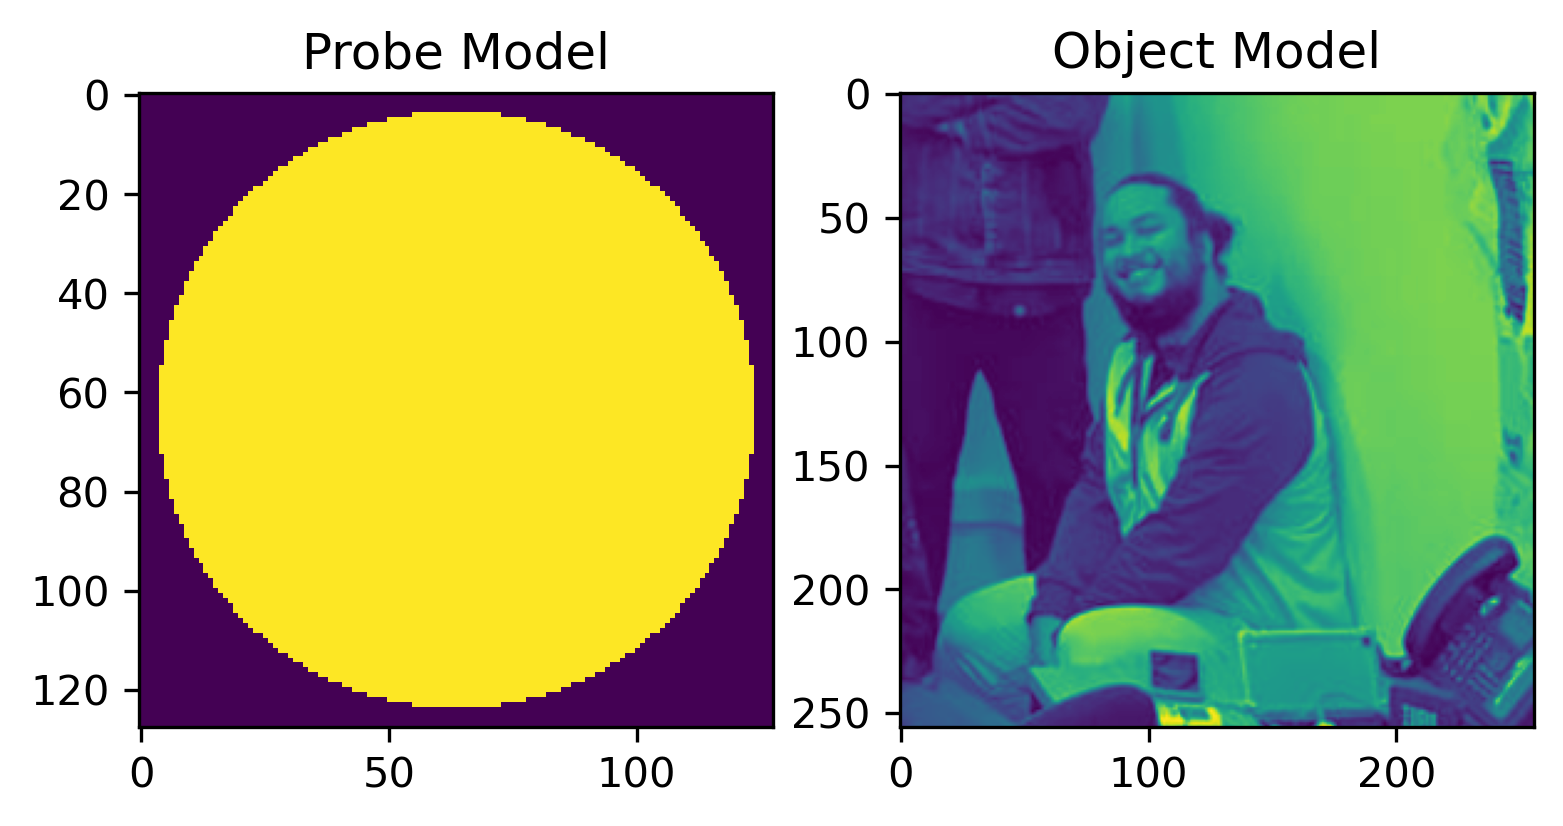

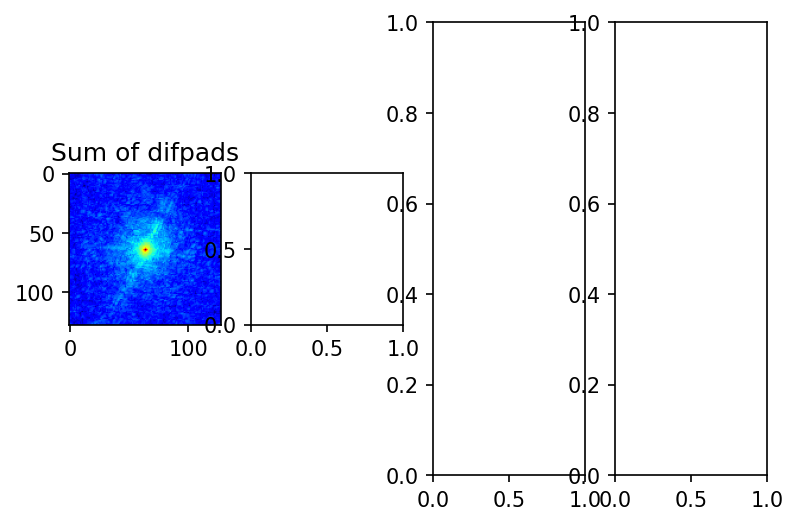

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cupy as cp
import datetime
import time
from PIL import Image

import random
random.seed(0)

def apply_random_shifts_to_positions(positions):
        random_shifts = [int(i) for i in np.random.rand(len(positions))*3]
        positions = np.asarray(positions) + np.asarray(random_shifts)
        return positions 

def get_positions_array(random_positions=False):
    positions = [2,16,32,64,96,126]
    # positions = [  2,  10,  18,  26,  34,  42,  50,  58,  66,  74,  82,  90,  98,  106, 114, 122]
    # positions = [2,   6,  10,  14,  18,  22,  26,  30,  34,  38,  42,  46,  50, 54,  58,  62,  66,  70,  74,  78,  82,  86,  90,  94,  98, 102, 106, 110, 114, 118, 122]

    if random_positions == True:
        positions = apply_random_shifts_to_positions(positions)

    positionsX,positionsY = np.meshgrid(positions,positions)
    positionsX = positionsX.flatten()
    positionsY = positionsY.flatten()

    return positionsX,positionsY

def apply_invalid_regions(difpad):
    delta = 25
    for i in range(0,difpad.shape[0]):
        difpad[0:difpad.shape[0]:delta] = -1

    for i in range(0,difpad.shape[1]):
        difpad[:,0:difpad.shape[1]:delta] = -1
    return  difpad
    
def get_simulated_data(random_positions=False,use_bad_points=False):

    positionsX,positionsY = get_positions_array(random_positions)
    
    dimension = 128 # Must be < than object!
    
    """ Create Probe """
    x = np.linspace(-1,1,dimension)
    X,Y = np.meshgrid(x,x)
    probe = np.where(X**2 + Y**2 < 0.9,1,0)  # Probe

    """ Create object """
    phase = np.array( np.load('image.npy')) # Load Imagem
    phase = phase - np.min(phase)
    phase = 2*np.pi*phase/np.max(phase) - np.pi # rescale from 0 to 2pi

    magnitude = Image.open('bernardi.png' ).convert('L').resize(phase.shape)
    magnitude = magnitude/np.max(magnitude)
    
    object = np.abs(magnitude)*np.exp(-1j*phase)

    if 1: # Plot initial guesses
        figure, subplot = plt.subplots(1,2,dpi=300)
        subplot[0].imshow(np.abs(probe))
        subplot[0].set_title('Probe Model')
        subplot[1].imshow(np.abs(object))
        subplot[1].set_title('Object Model')

    difpads = []
    for px,py in zip(positionsX,positionsY):

        """ Exit wave-field """
        W = object[py:py+dimension,px:px+dimension]*probe
    
        """ Propagation """
        difpad = np.fft.fft2(W)
        difpad = np.fft.fftshift(difpad)
        
        """ Measurement """
        difpad = np.absolute(difpad)**2
    
        if use_bad_points:# add invalid grid to data
            difpad = apply_invalid_regions(difpad)
                
        difpads.append(difpad)

    positionsitions = np.hstack((np.array([positionsY]).T ,np.array([positionsX]).T)) # adjust positionsitions format for proper input

    return difpads, positionsitions, object, probe


def propagate_beam(wavefront, dx, wavelength,distance,propagator='fourier'):
    """ Propagate a wavefront using fresnel ou fourier propagator

    Args:
        wavefront : the wavefront to propagate
        dx : pixel spacing of the wavefront input
        wavelength : wavelength of the illumination
        distance : distance to propagate
        propagator (str, optional): 'fresenel' or 'fourier'. Defaults to 'fresnel'.

    Returns:
        output: propagated wavefront
    """    
    from numpy.fft import fft2, fftshift, ifftshift, ifft2

    if propagator == 'fourier':
        if distance > 0:
            output = fftshift(fft2(fftshift(wavefront)))
        else:
            output = ifftshift(ifft2(ifftshift(wavefront)))            
    
    elif propagator == 'fresnel':
    
        ysize, xsize = wavefront.shape
        x_array = np.linspace(-xsize/2,xsize/2-1,xsize)
        y_array = np.linspace(-ysize/2,ysize/2-1,ysize)

        fx = x_array/(xsize)
        fy = y_array/(ysize)

        FX,FY = np.meshgrid(fx,fy)
        # Calculate approx phase distribution for each plane wave component
        w = FX**2 + FY**2 
        # Compute FFT
        F = fftshift(fft2(fftshift(wavefront)))
        # multiply by phase-shift and inverse transform 
        a = np.exp(-1j*np.pi*( distance*wavelength/dx**2)*w)
        output = ifftshift(ifft2(ifftshift(F*a)))

    return output


def RAAR_update_object(exit_waves, probe, object_shape, positions,epsilon=0.01):

    m,n = probe.shape
    k,l = object_shape

    probeSum  = np.zeros((k,l),dtype=complex)
    waveSum   = np.zeros((k,l),dtype=complex)
    probeInt  = np.abs(probe)**2
    conjProbe = np.conj(probe)

    for index, pos in enumerate((positions)):
        posy, posx = pos[0], pos[1]
        probeSum[posy:posy + m , posx:posx+n] = probeSum[posy:posy + m , posx:posx+n] + probeInt
        waveSum[posy:posy + m , posx:posx+n]  = waveSum[posy:posy + m , posx:posx+n]  + conjProbe*exit_waves[index] 

    object = waveSum/(probeSum + epsilon)

    return object


def RAAR_update_probe(exit_waves, obj, probe_shape,positions, epsilon=0.01):

    m,n = probe_shape

    objectSum = np.zeros((m,n),dtype=complex)
    waveSum = np.zeros((m,n),dtype=complex)
    objectInt = np.abs(obj)**2
    conjObject = np.conj(obj)

    for index, pos in enumerate((positions)):
        posy, posx = pos[0], pos[1]
        objectSum = objectSum + objectInt[posy:posy + m , posx:posx+n]
        waveSum = waveSum + conjObject[posy:posy + m , posx:posx+n]*exit_waves[index]

    probe = waveSum/(objectSum + epsilon)

    return probe


def RAAR_update_exit_wave(wavefront,measurement,distance,dx,wavelength,epsilon=0.01,propagator = 'fourier'):
    wave_at_detector = propagate_beam(wavefront, dx, wavelength,distance,propagator=propagator)
    corrected_wave = np.sqrt(measurement)*wave_at_detector/(np.abs(wave_at_detector)+epsilon)
    updated_exit_wave = propagate_beam(corrected_wave, dx, wavelength,-distance,propagator=propagator)
    return updated_exit_wave


def RAAR_loop(obj,probe,positions,difpads,beta,epsilon,distance,dx,wavelength, iterations,model):

    t0 = time.perf_counter()


    m,n = probe.shape
    
    exitWaves = np.zeros((len(positions),probe.shape[0],probe.shape[1]),dtype=complex)

    for index, pos in enumerate((positions)):
        posy, posx = pos[0], pos[1]
        reconBox = obj[posy:posy + m , posx:posx+n]
        exitWaves[index] = probe*reconBox

    error = []
    for iteration in range(0,iterations):

        if iteration%10==0: print('Iteration #',iteration)

        for index, pos in enumerate((positions)):
            posy, posx = pos[0], pos[1]
            reconBox = obj[posy:posy + m , posx:posx+n]
            waveToPropagate = 2*probe*reconBox-exitWaves[index]
            exitWaveNew = RAAR_update_exit_wave(waveToPropagate,difpads[index],distance,dx,wavelength,epsilon=epsilon)
            exitWaves[index] = beta*(exitWaves[index] + exitWaveNew) + (1-2*beta)*probe*reconBox

        probe = RAAR_update_probe(exitWaves, obj, probe.shape,positions, epsilon=epsilon)
        obj   = RAAR_update_object(exitWaves, probe, obj.shape, positions,epsilon=epsilon)

        error.append(np.sum(np.abs(model - obj))) #absolute error

        
    t1 = time.perf_counter()
    time_elapsed = t1-t0
    return obj, probe, error, time_elapsed


def mPIE_loop(difpads, positions,probe,object):

    t0 = time.perf_counter()

    mPIE = True
    use_rPIE_update_function = True
    correct_momentum = True

    offset = probe.shape[1]
    probeVelocity = 0
    objVelocity = 0
    T_counter = 0

    obj = cp.asarray(object)
    probe = cp.asarray(probe)

    error_list = []
    for j in range(iterations):

        print(f'Iteration {j+1}/{iterations}')
        error = 0
        O_aux = obj+0 
        P_aux = probe+0 
        for i in np.random.permutation(len(difpads)):  
            px = posX[i]
            py = posY[i]
            med = difpads[i]

            """ Exit wavefiled """
            W = obj[py:py+offset,px:px+offset]*probe

            """ Propagation """
            Pmm = cp.fft.fft2(W)
            
            error += cp.sum((cp.abs(Pmm[med >= 0]) - cp.sqrt(med[med >= 0]))**2)/ (cp.sum(cp.sqrt(med[med >= 0]**2)))  
            
            Pmm[med >= 0] = ((Pmm/cp.abs(Pmm))*cp.sqrt(med))[med >= 0]
            Pm = cp.fft.ifft2(Pmm)
            
            Diff = Pm - W

            #TODO: update only where difpad is valid?
            if use_rPIE_update_function: # rPIE update function
                obj[py:py+offset,px:px+offset] = obj[py:py+offset,px:px+offset] + gamma_obj*Diff*probe.conj()/ ( (1-alpha)*cp.abs(probe)**2+alpha*(cp.abs(probe)**2).max() )
                # P = P + gamma_probe*Diff*obj[py:py+offset,px:px+offset].conj()/ ( (1-beta)*cp.abs(P)**2+beta*(cp.abs(P)**2).max() )
                probe = probe + gamma_probe*Diff*obj[py:py+offset,px:px+offset].conj()/ ( (1-beta)*cp.abs(obj[py:py+offset,px:px+offset])**2+beta*(cp.abs(obj[py:py+offset,px:px+offset])**2).max() )
            else: #ePIE update function
                obj[py:py+offset,px:px+offset] = obj[py:py+offset,px:px+offset] + alpha*Diff*probe.conj()/(cp.abs(probe)**2).max()
                probe = probe + beta*Diff*obj[py:py+offset,px:px+offset].conj()/(cp.abs(obj)**2).max()
            
            if correct_momentum: # inside loop!
                if mPIE == True: # momentum addition
                    T_counter += 1 
                    if T_counter == T_lim : # T parameter in mPIE paper
                        probeVelocity  = probeVelocity*eta_probe + (probe - P_aux)
                        objVelocity = objVelocity*eta_obj  + (obj - O_aux)  
                        obj = O_aux + objVelocity
                        probe = P_aux + probeVelocity 
                        
                        O_aux = obj
                        P_aux = probe            
                        T_counter = 0
                        # T_counter = T_lim - 1
        
        error_list.append(error.get())

        if correct_momentum == False: # outside loop!
            if mPIE == True: # old momentum addition
                if j > 10 : # mPIE step?
                    gradO = obj - O_aux
                    gradP = probe - P_aux
                    probeVelocity = probeVelocity*eta_probe + gradP
                    objVelocity   = objVelocity*eta_obj + gradO
                    obj = O_aux + objVelocity
                    probe = P_aux + probeVelocity 
            
        # if 0:#j%100 == 0: # Print iteration
        #     figure, subplot = plt.subplots(1,2)
        #     subplot[0].imshow(np.abs(obj.get()),cmap='jet')
        #     subplot[1].imshow(np.abs(probe.get()),cmap='jet')
        #     subplot[0].set_title('Object')
        #     subplot[1].set_title('Probe')
        #     figure.suptitle(f'Iteration #{j}')
        #     plt.show()
        #     plt.close()

    probe = probe.get() # get from cupy to numpy
    obj = obj.get()

    t1 = time.perf_counter()
    time_elapsed = t1-t0
    
    return obj, probe, error, time_elapsed

    
""" MAIN CODE """
    
difpads, positions, model_obj, model_probe = get_simulated_data()

probe_guess = model_probe
obj_guess = np.ones_like(model_obj) # constant object

if 1:
    figure, ax = plt.subplots(2,4,dpi=150)
    ax[0,0].imshow(np.sum(difpads,axis=0),norm=LogNorm(),cmap='jet')
    ax[0,0].set_title("Sum of difpads")
    ax[0,1].imshow(np.abs(model_obj),cmap='jet')
    ax[0,1].set_title("Model Magnitude")
    ax[0,2].imshow(np.angle(model_obj),cmap='jet')
    ax[0,2].set_title("Model Phase")
    ax[1,0].imshow(probe_guess,cmap='jet')
    ax[1,0].set_title("Probe guess")


""" Parameters """
iterations = 30
distance = 30  # meters
energy = 10    # keV
n_pixels = 3072
pixel_size = 55.13e-6  # meters
c_speed = 299792458    # Velocity of Light [m/s]
planck  = 4.135667662E-18  # Plank constant [keV*s]
wavelength = c_speed * planck / energy
dx = wavelength*distance/(n_pixels*pixel_size)
print('Object pixel size:',dx)
print("Oversampling: ?")

""" mPIE params """
if 1: # suggested min from paper
    alpha, beta = 0.05, 0.5
    gamma_obj, gamma_probe = 0.1, 0.2
    eta_obj, eta_probe = 0.5, 0.75
    T_lim = 10
else: #suggested max
    alpha, beta = 0.25, 5
    gamma_obj, gamma_probe = 0.5, 1
    eta_obj, eta_probe = 0.9, 0.99
    T_lim = 100 

""" RAAR params """
beta = 0.995
epsilon = 0.01

if 0: #mPIE
    # PIE_obj, PIE_probe, PIE_error, PIE_time = mPIE()
    pass

if 1: #RAAR 
    RAAR_obj, RAAR_probe, RAAR_error, RAAR_time = RAAR_loop(obj_guess,probe_guess,positions,difpads,beta,epsilon,distance,dx,wavelength, iterations,model_obj)

    figure, subplot = plt.subplots(2,3,figsize=(10,10))
    subplot[0,0].imshow(np.abs(model_obj))   
    subplot[0,1].imshow(np.angle(model_obj))   
    subplot[0,2].imshow(probe_guess)
    subplot[1,0].imshow(np.abs(RAAR_obj))   
    subplot[1,1].imshow(np.angle(RAAR_obj))
    subplot[1,2].imshow(np.abs(RAAR_probe))
    subplot[0,0].set_title('Object Magnitude')
    subplot[0,1].set_title('Object Phase')
    subplot[0,2].set_title('Probe Magnitude')


    figure, ax = plt.subplots(dpi=300)
    ax.plot(RAAR_error,'-o' )
    ax.grid()
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Error')

